In [1]:
%config Completer.use_jedi = False

# import ipywidgets as widgets
import pandas as pd
from datetime import datetime

import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt

import glob

import numpy as np

import seaborn as sns

In [2]:
data_df = pd.concat([pd.read_csv(f, parse_dates=['Date'], index_col=['Date']) for f in glob.glob('../Data/Nifty/OHLC/*.csv',)], 
                    join='outer')

options_df = pd.concat([pd.read_csv(f, parse_dates=['Date'], index_col=['Date']) for f in glob.glob('../Data/Nifty/Options/*.csv',)], 
                    join='outer')

# Filter for latest data
options_df = options_df[options_df.index.max()==options_df.index]

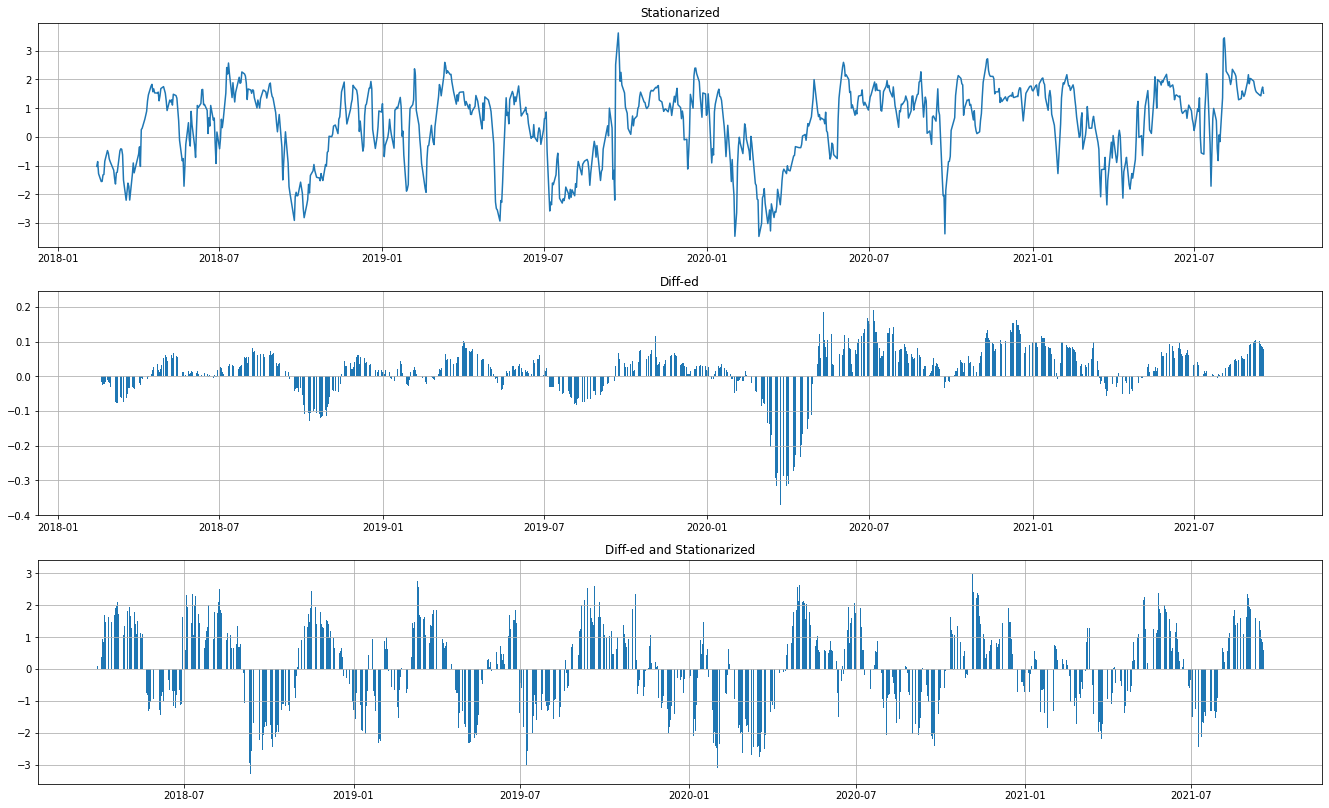

In [3]:
period = 30 # used as window size for smoothing
fig = plt.figure(figsize=(23,14))
ax = fig.add_subplot(311)
ax.plot(data_df.Close.rolling(period).apply(lambda x: (x[-1]-x.mean())/x.std()))
ax.grid()
ax.set_title('Stationarized')
ax = fig.add_subplot(312)
ax.bar(data_df.index, data_df.Close.rolling(period).apply(lambda x: (x[-1]-x[0])/x[0]))
ax.set_title('Diff-ed')
ax.grid()
ax = fig.add_subplot(313)
ax.bar(data_df.index, data_df.Close.rolling(period).apply(lambda x: (x[-1]-x[0])).rolling(period).apply(lambda x: (x[-1]-x.mean())/x.std()))
ax.set_title('Diff-ed and Stationarized')
# ax.bar(data_df.index, (data_df.Open - data_df.Close).rolling(20).apply(lambda x: (x[-1]-x.mean())/x.std()))
ax.grid()

In [4]:
trade_days_left = 3 # used as window size
period_change = data_df.Close.rolling(trade_days_left).apply(lambda x: (x[-1]-x[0])/x[0]).dropna()

In [83]:
period_open = data_df.Open.rolling(trade_days_left).apply(lambda x: x[0]).dropna()

period_high = data_df.High.rolling(trade_days_left).apply(lambda x: x.max()).dropna()

period_low = data_df.Low.rolling(trade_days_left).apply(lambda x: x.min()).dropna()

In [111]:
period_pos_change = (period_high - period_open)/period_open
period_neg_change = (period_low - period_open)/period_open

Let's visualize the distribution of how much the underlying can change within the period

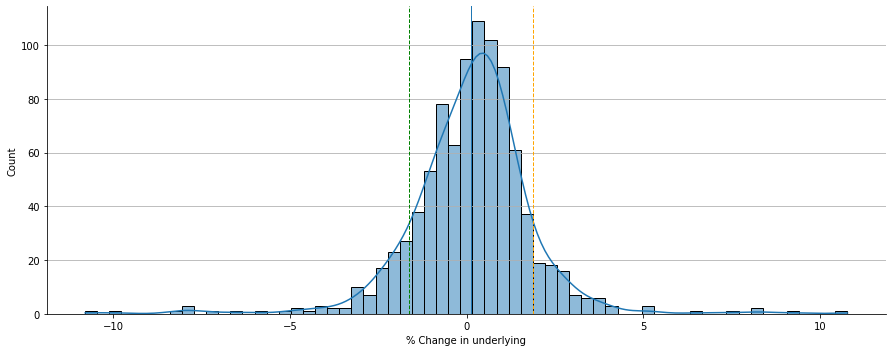

In [112]:
ax = sns.displot(data=period_change*100,kde=True, aspect=2.5)
ax.set_axis_labels(x_var='% Change in underlying')
plt.grid(axis='y')

plt.axvline(x=100*period_change.mean(), 
#             color='blue', 
            linewidth=1.0, 
            linestyle='-')
plt.axvline(x=100*(period_change.mean()-period_change.std()), 
            color='green', 
            linewidth=1.0, 
            linestyle='--')
plt.axvline(x=100*(period_change.mean()+period_change.std()), 
            color='orange', 
            linewidth=1.0, 
            linestyle='--')

# Probability of change
**Probability of $mean \pm \sigma$ change**

In [113]:
expected_change_neg_sigma = period_change.mean() - period_change.std()
prob_change_neg_sigma = (period_change<expected_change_neg_sigma).sum()/len(period_change)
print("%.3f probability of < %.2f%% change" %(prob_change_neg_sigma, expected_change_neg_sigma*100))

0.107 probability of < -1.63% change


In [114]:
expected_change_pos_sigma = period_change.mean() + period_change.std()
prob_change_pos_sigma = (period_change>expected_change_pos_sigma).sum()/len(period_change)
print("%.3f probability of > %.f%% change" %(prob_change_pos_sigma, expected_change_pos_sigma*100))

0.092 probability of > 2% change


**Probability of $\pm 1$% change**

In [115]:
expected_change = 0.01
prob_change = (period_change>expected_change).sum()/len(period_change)
print("%.3f probability of > %.f%% change" %(prob_change, expected_change*100))

prob_change = (period_change<-expected_change).sum()/len(period_change)
print("%.3f probability of < -%.f%% change" %(prob_change, expected_change*100))

0.241 probability of > 1% change
0.188 probability of < -1% change


**Probability of $\pm 2$% change**

In [116]:
expected_change = 0.02
prob_change = (period_change>expected_change).sum()/len(period_change)
print("%.3f probability of > %.f%% change" %(prob_change, expected_change*100))

prob_change = (period_change<-expected_change).sum()/len(period_change)
print("%.3f probability of < -%.f%% change" %(prob_change, expected_change*100))

0.085 probability of > 2% change
0.078 probability of < -2% change


**Probability of hitting upper levels and lower levels**

In [117]:
# Set the last price
last_price = data_df.Close[-1]

In [118]:
# Set the last price
last_price = 17396

In [138]:
upper_level = 17750
expected_change = (upper_level - last_price)/last_price
prob_change = (period_change>expected_change).sum()/len(period_change)
print("%.3f probability of expiring above %d" %(prob_change, upper_level))

lower_level = 17000
expected_change = (lower_level - last_price)/last_price
prob_change = (period_change<expected_change).sum()/len(period_change)
print("%.3f probability of expiring below %d" %(prob_change, lower_level))

0.081 probability of expiring above 17750
0.059 probability of expiring below 17000


In [146]:
upper_level = 17750
expected_change = (upper_level - last_price)/last_price
prob_change = (period_pos_change>expected_change).sum()/len(period_change)
print("%.3f probability of reaching %d in %d days" %(prob_change, upper_level, trade_days_left))

lower_level = 16950
expected_change = (lower_level - last_price)/last_price
prob_change = (period_neg_change<expected_change).sum()/len(period_change)
print("%.3f probability of reaching %d in %d days" %(prob_change, lower_level, trade_days_left))

0.152 probability of reaching 17750 in 3 days
0.135 probability of reaching 16950 in 3 days


In [120]:
# Get rid of contracts which are not actively traded
options_df = options_df[options_df['No. of contracts']>1000]

In [121]:
upper_bound = 18750
lower_bound = 16750
options_df = options_df[options_df['Strike Price']<upper_bound]
options_df = options_df[options_df['Strike Price']>lower_bound]

In [122]:
def add_option_lines(ce_positions, pe_positions, last_price=None, line_width=2.0):
    if last_price is not None:
        plt.axvline(x=last_price, color='royalblue', linewidth=line_width, linestyle='--', label="Last Close: %d"%last_price)
        
    for ce_contract in ce_positions:
        plt.axvline(x=ce_contract, color='darkgreen', linewidth=line_width, linestyle='--', label="%d CE"%ce_contract)
    
    for pe_contract in pe_positions:
        plt.axvline(x=pe_contract, color='tomato', linewidth=line_width, linestyle='--', label="%d PE"%pe_contract)

In [130]:
capital = 5000
lot_size = 50
expected_rate = 0.1
tax = 20 # placeholder in Rs
capital_breakeven = (capital*(1+expected_rate)+tax)/lot_size

In [131]:

# Separate out Call and Put option
ce_df = options_df[options_df['Option Type']=='CE']
pe_df = options_df[options_df['Option Type']=='PE']

# Filter out ITM
ce_df = ce_df[ce_df['Strike Price']>last_price]
pe_df = pe_df[pe_df['Strike Price']<last_price]


ce_df = ce_df.sort_values('Strike Price')
pe_df = pe_df.sort_values('Strike Price')

# Filter out options we can't invest in due to capital constraints
ce_df = ce_df[(ce_df['LTP']*lot_size)<capital]
pe_df = pe_df[(pe_df['LTP']*lot_size)<capital]

# Change percent required to break even on the full capital
ce_change_breakeven = ((ce_df['Strike Price'] + capital_breakeven - last_price)/last_price).values
pe_change_breakeven = ((pe_df['Strike Price'] - capital_breakeven - last_price)/last_price).values

# Change percent
ce_change = ((ce_df['Strike Price'] - last_price)/last_price).values
pe_change = ((pe_df['Strike Price'] - last_price)/last_price).values


# Calculate Probabilty of call options breeaking even on the entire capital
proba_breakeven_ce = np.zeros_like(ce_change_breakeven)
for idx in range(len(ce_df)):
    proba_breakeven_ce[idx] = np.apply_along_axis(lambda x : x > ce_change_breakeven[idx],
                                                   axis=0,
                                                   arr=period_pos_change).mean()
#                                                    arr=period_change).mean()

strike_price_ce = ce_df['Strike Price'].values

# Calculate Probabilty of out of the money put options expiring in the moeny
proba_breakeven_pe = np.zeros_like(pe_change_breakeven)
for idx in range(len(pe_df)):
    proba_breakeven_pe[idx] = np.apply_along_axis(lambda x : x < pe_change_breakeven[idx],
                                                axis=0,
                                                arr=period_neg_change).mean()
#                                                 arr=period_change).mean()

strike_price_pe = pe_df['Strike Price'].values

# Calculate Probabilty of out of the money call options expiring in the money
proba_atm_expiry_ce = np.zeros_like(ce_change)
for idx in range(len(ce_df)):
    proba_atm_expiry_ce[idx] = np.apply_along_axis(lambda x : x > ce_change[idx],
                                                   axis=0,
                                                   arr=period_change).mean()


# Calculate Probabilty of out of the money put options expiring in the moeny
proba_atm_expiry_pe = np.zeros_like(pe_change)
for idx in range(len(pe_df)):
    proba_atm_expiry_pe[idx] = np.apply_along_axis(lambda x : x < pe_change[idx],
                                                axis=0,
                                                arr=period_change).mean()

sigma_high = last_price*(1+expected_change_pos_sigma)
sigma_low = last_price*(1+expected_change_neg_sigma)
# Profits when underlying expires at mean +/- std
probable_profits_ce = lot_size*(sigma_high-strike_price_ce)
probable_profits_pe = lot_size*(strike_price_pe-sigma_low)

# Zero out the loss making contracts
probable_profits_pe[probable_profits_pe<0] = 0
probable_profits_ce[probable_profits_ce<0] = 0


In [132]:
ce_positions = [17550]
pe_positions = [17200]

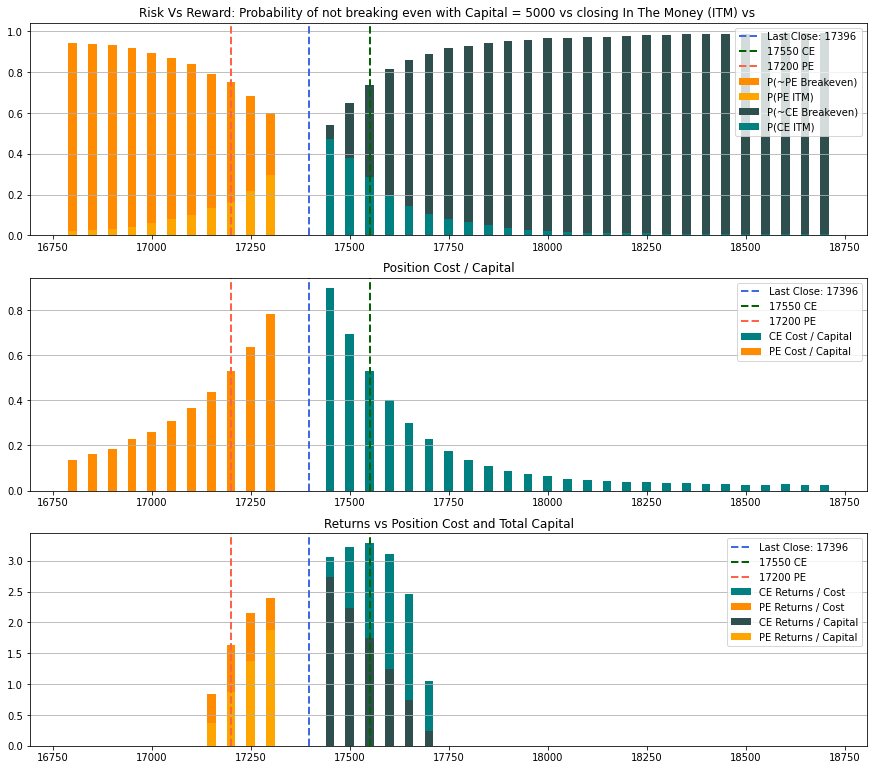

In [147]:
cost_ce = lot_size*ce_df['Close'].values
cost_pe = lot_size*pe_df['Close'].values

# Break Even Analysis
fig = plt.figure(figsize=(15,18))

ax = fig.add_subplot(411)



# Plot PE
ax.bar(x=strike_price_pe, 
       height=1-proba_breakeven_pe, 
       width=22, 
       color='darkorange', 
       align='center', 
       label='P(~PE Breakeven)')


# Plot PE
ax.bar(x=strike_price_pe, height=proba_atm_expiry_pe, 
       width=22,
       color='orange', 
       align='center', 
       label='P(PE ITM)')


# Plot CE
ax.bar(x=strike_price_ce, 
       height=1-proba_breakeven_ce, 
       width=22, 
       color='darkslategray', 
       align='center', 
       label='P(~CE Breakeven)')


# Plot CE
ax.bar(x=strike_price_ce, 
       height=proba_atm_expiry_ce, 
       width=22, 
       color='teal', 
       align='center', 
       label='P(CE ITM)')


# ax.grid()
ax.set_title('Risk Vs Reward: Probability of not breaking even with Capital = %d vs closing In The Money (ITM) vs '%capital)


add_option_lines(ce_positions=ce_positions,pe_positions=pe_positions, last_price=last_price)
ax.legend()
ax.grid(axis='y')



# Probable profit analysis

ax = fig.add_subplot(413)

ax.set_title('Returns vs Position Cost and Total Capital')

# Plot CE
ax.bar(x=strike_price_ce, 
       height=probable_profits_ce/cost_ce, 
       width=22, 
       color='teal', 
       align='center', 
       label='CE Returns / Cost')


# Plot PE
ax.bar(x=strike_price_pe, 
       height=probable_profits_pe/cost_pe, 
       width=22, 
       color='darkorange', 
       align='center', 
       label='PE Returns / Cost')


# Plot CE
ax.bar(x=strike_price_ce, 
       height=probable_profits_ce/capital, 
       width=22, 
       color='darkslategray', 
       align='center', 
       label='CE Returns / Capital')


# Plot PE
ax.bar(x=strike_price_pe, 
       height=probable_profits_pe/capital, 
       width=22, 
       color='orange', 
       align='center', 
       label='PE Returns / Capital')

add_option_lines(ce_positions=ce_positions,pe_positions=pe_positions, last_price=last_price)
ax.legend()
ax.grid(axis='y')

ax = fig.add_subplot(412)

ax.set_title('Position Cost / Capital')

# Plot CE
ax.bar(x=strike_price_ce, 
       height= cost_ce/capital, 
       width=22, 
       color='teal', 
       align='center', 
       label='CE Cost / Capital')


add_option_lines(ce_positions=ce_positions,pe_positions=pe_positions, last_price=last_price)

# Plot PE
ax.bar(x=strike_price_pe, 
       height= cost_pe/capital, 
       width=22, 
       color='darkorange', 
       align='center', 
       label='PE Cost / Capital')

ax.legend()
ax.grid(axis='y')


